# Multi-layer perceptron

In this notebook, different multi-layer perceptron architectures are used to predict smoking status based on clinical and biological features. The focus is on comparing network depths, optimizers and data sampling strategies to optimize predictive performance.

### MLP Architectures

Three MLP models are considered:

* `model1` – a simple feedforward network with two hidden layers (32 → 16 neurons) and dropout,
* `model2` – a deeper network with three hidden layers (128 → 64 → 32 neurons), batch normalization and higher dropout,
* `model3` – a residual MLP with skip connections, two hidden layers (64 neurons each) and batch normalization for more stable training.

### Experiments

The notebook explores:

1. training each model on original, oversampled and undersampled datasets,
2. evaluating performance using accuracy, F1-score and ROC-AUC with k-fold cross-validation,
3. comparing optimizers (Adam vs. SGD) and early stopping to prevent overfitting,
4. analyzing per-fold performance and selecting the best-performing model configuration.

The ultimate goal is to identify the MLP architecture and training setup that achieves the highest predictive performance for smoking status.

## Preprocessing

In [1]:
import pandas as pd
df = pd.read_csv('smoking.csv')

## Input data description
The first five rows of the dataset are shown below using the `head()` function. The dataset contains 27 attributes, as shown below.

In [2]:
df.head()

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0


A brief description of the data will be displayed using the `info()` function. This function shows general information about the data, such as the number of rows, data types, and any missing values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

The dataset consists of 55,692 samples, each with a range of clinical and biological features. Most attributes are numeric, with data types being either `int64` or `float64`.

Three fields are exceptions: `gender`, which describes the gender of the patient examined; `oral`, which describes the patient's oral health; and `tartar`, which describes whether the patient has tartar. The type of these attributes is object, the parent class for all text objects created in Python.

The values of these three fields are repeatable, meaning they constitute categorical values.

Therefore, it is worth checking the repeatability of this data.

In [4]:
df["gender"].value_counts()

gender
M    35401
F    20291
Name: count, dtype: int64

In [5]:
df["oral"].value_counts()

oral
Y    55692
Name: count, dtype: int64

In [6]:
df["tartar"].value_counts()

tartar
Y    30940
N    24752
Name: count, dtype: int64

Interestingly, both the `gender` and `tartar` attribute values are binary (containing only two categories). However, the `oral` attribute value has only one category for all rows, which leads us to conclude that this column can be removed.

Both binary attributes will therefore be converted to binary values using one-hot encoding.

In [7]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(df[['gender', 'oral', 'tartar']])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['gender', 'oral', 'tartar']))

df.drop(['gender', 'oral', 'tartar'], axis=1, inplace=True)
df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)

print(df.columns)

Index(['ID', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking', 'gender_M', 'tartar_Y'],
      dtype='object')


After performing this operation, new binary columns were created for both columns. Each of these columns represents one of the unique values, and the rows contain the values 0 or 1.

## Exploratory Data Analysis
Analyzing all numeric fields with the `describe()` method allows the developer to summarize numeric attributes. This includes the mean, standard deviation, minimum, maximum, and other values describing the data.

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,55692.0,27845.500000,16077.039933,0.0,13922.75,27845.5,41768.25,55691.0
age,55692.0,44.182917,12.071418,20.0,40.00,40.0,55.00,85.0
height(cm),55692.0,164.649321,9.194597,130.0,160.00,165.0,170.00,190.0
weight(kg),55692.0,65.864936,12.820306,30.0,55.00,65.0,75.00,135.0
waist(cm),55692.0,82.046418,9.274223,51.0,76.00,82.0,88.00,129.0
eyesight(left),55692.0,1.012623,0.486873,0.1,0.80,1.0,1.20,9.9
eyesight(right),55692.0,1.007443,0.485964,0.1,0.80,1.0,1.20,9.9
hearing(left),55692.0,1.025587,0.157902,1.0,1.00,1.0,1.00,2.0
hearing(right),55692.0,1.026144,0.159564,1.0,1.00,1.0,1.00,2.0
systolic,55692.0,121.494218,13.675989,71.0,112.00,120.0,130.00,240.0


The `describe()` function call shows that there are 55,692 non-null values for each column, meaning there are no null values for any column in the dataset.

From these values, it can be observed that the standard deviations differ across features, suggesting that the data has not been standardized. The mean values also differ across features, suggesting that the data has not been normalized. This may be due to differences in the units in which the data is expressed and the ranges between different columns.

It can be observed that many columns have values that are more than three standard deviations from the mean. For example, the `age` column has a value of 80 within three standard deviations of the mean. The maximum value in this column is 85. A person with this age appears to be an outlier. It's difficult to determine whether a person smokes as they become elders, when many disorders are more likely due to age.

In [9]:
import numpy as np

z_scores = np.abs((df['age'] - df['age'].mean()) / df['age'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['weight(kg)'] - df['weight(kg)'].mean()) / df['weight(kg)'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['height(cm)'] - df['height(cm)'].mean()) / df['height(cm)'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['waist(cm)'] - df['waist(cm)'].mean()) / df['waist(cm)'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['eyesight(left)'] - df['eyesight(left)'].mean()) / df['eyesight(left)'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['eyesight(right)'] - df['eyesight(right)'].mean()) / df['eyesight(right)'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['hearing(left)'] - df['hearing(left)'].mean()) / df['hearing(left)'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['hearing(right)'] - df['hearing(right)'].mean()) / df['hearing(right)'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['systolic'] - df['systolic'].mean()) / df['systolic'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['relaxation'] - df['relaxation'].mean()) / df['relaxation'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['fasting blood sugar'] - df['fasting blood sugar'].mean()) / df['fasting blood sugar'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['Cholesterol'] - df['Cholesterol'].mean()) / df['Cholesterol'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['triglyceride'] - df['triglyceride'].mean()) / df['triglyceride'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['HDL'] - df['HDL'].mean()) / df['HDL'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['LDL'] - df['LDL'].mean()) / df['LDL'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['hemoglobin'] - df['hemoglobin'].mean()) / df['hemoglobin'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['Urine protein'] - df['Urine protein'].mean()) / df['Urine protein'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['serum creatinine'] - df['serum creatinine'].mean()) / df['serum creatinine'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['AST'] - df['AST'].mean()) / df['AST'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['ALT'] - df['ALT'].mean()) / df['ALT'].std())
df_filtered = df[z_scores <= 3]

z_scores = np.abs((df['Gtp'] - df['Gtp'].mean()) / df['Gtp'].std())
df_filtered = df[z_scores <= 3]


print("Num of rows before filtration:", len(df))
print("Num of rows after filtration:", len(df_filtered))

Num of rows before filtration: 55692
Num of rows after filtration: 54787


# Target analysis

The target of the prediction is the `smoking` column, which assigns a person with given biological parameters to one of two categories (smoker or non-smoker).

When working with a classification problem, it's worth examining how the data is represented in the label column.

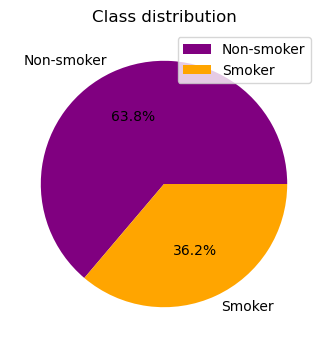

In [10]:
import matplotlib.pyplot as plt

target_dis = df_filtered['smoking'].value_counts()
plt.figure(figsize=(6, 4))
target_dis.plot(kind='pie', labels=['Non-smoker', 'Smoker'], autopct='%1.1f%%', colors=['purple', 'orange'])
plt.title('Class distribution')
plt.ylabel('')

plt.legend(loc='upper right')

plt.show()

It can be seen that the majority of the patients studied, nearly 2/3, are non-smokers. This column is unbalanced because one class occurs significantly more frequently than the other, which impacts the performance of the classification model.

Because of the 55k data in the `smoking.csv` dataset, we can afford both oversampling and undersampling. However, in the case of this model, due to its small size, oversampling may be the preferred approach, i.e., duplicating rows from a class that is significantly less numerous in the dataset.

## Oversampling

Oversampling is a technique for duplicating random rows from the minority class. Oversampling increases the number of data points in the dataset.

To balance these two groups, the $RandomOverSampler$ method from the `imbalanced-learn` library will be used, which randomly duplicates samples from the minority class.

In [11]:
from imblearn.over_sampling import RandomOverSampler

X = df_filtered.drop('smoking', axis=1)
y = df_filtered['smoking']

over_sampler = RandomOverSampler(random_state=42)
X_over, y_over = over_sampler.fit_resample(X, y)

The code below shows what label splitting occurs before oversampling and after executing the $RandomOverSampler$ method.

In [12]:
print("Num of samples before oversampling:")
print(y.value_counts())   

print("\nNum of samples after oversampling:")
print(y_over.value_counts())

df_oversampled = pd.concat([pd.DataFrame(X_over, columns=X.columns), y_over.reset_index(drop=True)], axis=1)

Num of samples before oversampling:
smoking
0    34958
1    19829
Name: count, dtype: int64

Num of samples after oversampling:
smoking
0    34958
1    34958
Name: count, dtype: int64


And this is how the label column values ​​are now distributed in the pie chart.

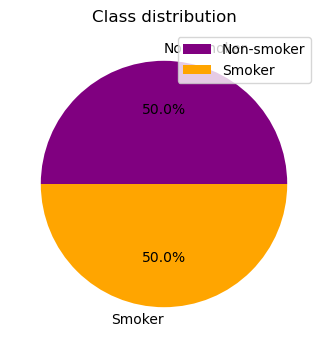

In [13]:
target_oversampled = df_oversampled['smoking'].value_counts()
plt.figure(figsize=(6, 4))
target_oversampled.plot(kind='pie', labels=['Non-smoker', 'Smoker'], autopct='%1.1f%%', colors=['purple', 'orange'])
plt.title('Class distribution')
plt.ylabel('')

plt.legend(loc='upper right')

plt.show()

## Undersampling

This method involves removing data from the majority class. Random records are removed from the majority sample until both classes have the same cardinality.

To balance these two groups, the $NearMiss$ method from the imbalanced-learn library is used, which reduces the number of samples from the dominant class to balance the proportions of classes in the dataset.

In [14]:
from imblearn.under_sampling import NearMiss

under_sampler = NearMiss()
X_under, y_under = under_sampler.fit_resample(X, y)

The code below shows what label splitting occurs before undersampling and after executing the $NearMiss$ method.

In [15]:
print("Num of samples before undersampling:")
print(y.value_counts())   

print("\nNum of samples after undersampling:")
print(y_under.value_counts())

df_undersampled = pd.concat([pd.DataFrame(X_under, columns=X.columns), y_under.reset_index(drop=True)], axis=1)

Num of samples before undersampling:
smoking
0    34958
1    19829
Name: count, dtype: int64

Num of samples after undersampling:
smoking
0    19829
1    19829
Name: count, dtype: int64


In this case, the values in the `smoking` column are also distributed 1:1. However, the size of the dataset changes, from 70,474 to 40,910 rows.

Next, the dataset will be splitted into data (removing the `ID` column) and labels, standardize the data, and divide the dataset into training and test sets.

## Scaling and partitioning into sets

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
TEST_SIZE = 0.2
RANDOM_STATE = 42

The dataset will now be divided into two parts: features and labels.

Features are columns based on which the model will assign an object (in this case, the patient being tested) to one of two categories. These include all columns except for `smoking`, `ID` (the `ID` is an irrelevant feature) and the `oral` attribute, which has only one value (a feature that provides no significant information).

Labels (also known as targets) are the values to be predicted. The target column will be `smoking` meaning whether the patient smokes.

The prepared and standardized data will also be divided into a training set and a test set. The training set contains 80% of the entire data set, while the test set contains 20%. Setting the `random_state` parameter ensures that the data will be divided into the same sets each time it is run.

In [18]:
# Original data
X_orig = df_filtered.drop(['smoking', 'ID'], axis=1)
y_orig = df_filtered['smoking']
X_orig_scaled = scaler.fit_transform(X_orig)
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
    X_orig_scaled, y_orig, test_size=TEST_SIZE, stratify=y_orig, random_state=RANDOM_STATE
)

# Oversampled
X_over_scaled = scaler.fit_transform(df_oversampled.drop(['smoking', 'ID'], axis=1))
y_over = df_oversampled['smoking']
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(
    X_over_scaled, y_over, test_size=TEST_SIZE, stratify=y_over, random_state=RANDOM_STATE
)

# Undersampled
X_under_scaled = scaler.fit_transform(df_undersampled.drop(['smoking', 'ID'], axis=1))
y_under = df_undersampled['smoking']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(
    X_under_scaled, y_under, test_size=TEST_SIZE, stratify=y_under, random_state=RANDOM_STATE
)

print("Original:", X_orig_train.shape, X_orig_test.shape)
print("Oversampled:", X_over_train.shape, X_over_test.shape)
print("Undersampled:", X_under_train.shape, X_under_test.shape)

Original: (43829, 24) (10958, 24)
Oversampled: (55932, 24) (13984, 24)
Undersampled: (31726, 24) (7932, 24)


To facilitate the selection of a given method, a `get_dataset` function will be created, which will return training and test data divided into `data` and `target`.

In [19]:
def get_dataset(kind='over'):
    """Returns (X_train, X_test, y_train, y_test) for the given data type"""
    if kind == 'over':
        return X_over_train, X_over_test, y_over_train, y_over_test
    elif kind == 'under':
        return X_under_train, X_under_test, y_under_train, y_under_test
    else:
        return X_orig_train, X_orig_test, y_orig_train, y_orig_test

# Model training

In [30]:
import torch

torch.manual_seed(42)
np.random.seed(42)

Models will be trained for every method in an half-automated way using different configs given below.

In [31]:
config = ['orig', 'over', 'under']
results = []

A neural network model will be created in a function that returns the model, the cross-entropy method and the optimizer. The network consists of three linear layers:
* The first layer accepts `input_dim` input arguments and transforms them into 64 outputs.
* The second layer has 64 inputs (from the output of the previous layer) and transforms them into 32 outputs.
* The third layer has 32 inputs and produces 1 output.

To improve performance and avoid overfitting, the network includes the following components:
- **Batch Normalization** after the first linear layer, which normalizes the activations to improve training speed and stability.
- **ReLU Activation** function after the first and second layers, which applies the function `max(0, x)` to introduce nonlinearity and help the network learn complex relationships.
- **Dropout** with a rate of 0.3, applied after the ReLU activation, which helps prevent overfitting by randomly setting some of the neuron outputs to zero during training.
- **Sigmoid Activation** at the output layer, which maps the final output to a value between 0 and 1, representing the probability of the sample belonging to one of the two classes.

After passing through the model, the output should be the probability that a given sample belongs to one of the two classes.

To evaluate the model, the cross-entropy method will be used ($Binary Cross Entropy Loss$). The `BCELoss()` function calculates the loss between the predicted and actual labels.

Model training will be performed by updating weights to minimize the loss function. This is achieved by the `Adam` algorithm, which uses backpropagation to calculate the gradients of the loss function across all model weights and then assigns new weights.

In [32]:
import torch.nn as nn
import torch.optim as optim

def create_model(input_dim):
    model = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return model, criterion, optimizer

The data will then be trained and evaluated using a loop that iterates through the data prepared using each method and compares their effectiveness.

Data training will be performed in a large block of code. The tasks performed will be as follows:
1. The code is prepared to train the model using `PyTorch`. The training and test data/labels is transformed into a tensor using `torch.tensor()`.
2. The training and test data is combined into input-output pairs using the `TensorData` class, making them easier to use in the model. The `DataLoader` class is used to create iterators that allow the data to be split into equal-sized chunks and fed to the model.
3. Calling the function that returns the model, the cross-entropy method and the optimizer.
4. During training, the neural network model is trained in 40 epochs. Each epoch represents a loop through the entire training set, allowing the model to learn on the entire dataset.
5. To evaluate the model's performance, we will loop through mini-batches consisting of data and training labels. For each mini-batch, the data will be fed to the model for prediction, and then a loss function will be calculated. Based on the loss function obtained at the end of the loop, the model's ability to handle new data can by determined.
6. Evaluation metrics are added to the results. Each dictionary includes the dataset name, model accuracy, F1-score, which considers the model's precision and sensitivity, and ROC-AUC, which measures the model's ability to distinguish classes.
7. Finally, model training graphs are created on the given datasets.

Data type: 'orig'

Epoch: 1/40, Loss (training): 0.4906
Epoch: 2/40, Loss (training): 0.4673
Epoch: 3/40, Loss (training): 0.4641
Epoch: 4/40, Loss (training): 0.4620
Epoch: 5/40, Loss (training): 0.4604
Epoch: 6/40, Loss (training): 0.4585
Epoch: 7/40, Loss (training): 0.4583
Epoch: 8/40, Loss (training): 0.4574
Epoch: 9/40, Loss (training): 0.4557
Epoch: 10/40, Loss (training): 0.4549
Epoch: 11/40, Loss (training): 0.4544
Epoch: 12/40, Loss (training): 0.4559
Epoch: 13/40, Loss (training): 0.4541
Epoch: 14/40, Loss (training): 0.4539
Epoch: 15/40, Loss (training): 0.4534
Epoch: 16/40, Loss (training): 0.4533
Epoch: 17/40, Loss (training): 0.4519
Epoch: 18/40, Loss (training): 0.4513
Epoch: 19/40, Loss (training): 0.4518
Epoch: 20/40, Loss (training): 0.4525
Epoch: 21/40, Loss (training): 0.4513
Epoch: 22/40, Loss (training): 0.4502
Epoch: 23/40, Loss (training): 0.4489
Epoch: 24/40, Loss (training): 0.4490
Epoch: 25/40, Loss (training): 0.4489
Epoch: 26/40, Loss (training): 0.4495
Ep

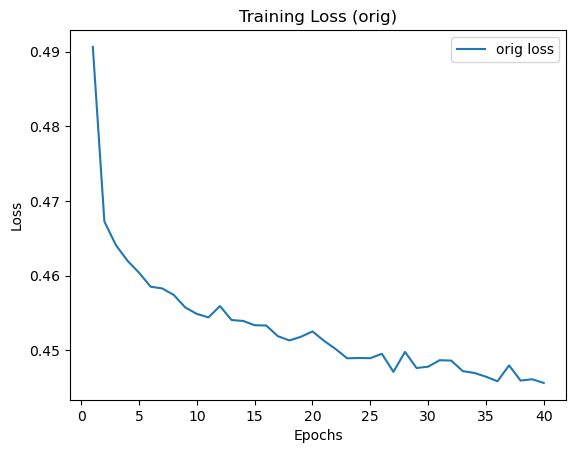

Data type: 'over'

Epoch: 1/40, Loss (training): 0.5016
Epoch: 2/40, Loss (training): 0.4848
Epoch: 3/40, Loss (training): 0.4797
Epoch: 4/40, Loss (training): 0.4768
Epoch: 5/40, Loss (training): 0.4757
Epoch: 6/40, Loss (training): 0.4751
Epoch: 7/40, Loss (training): 0.4738
Epoch: 8/40, Loss (training): 0.4726
Epoch: 9/40, Loss (training): 0.4721
Epoch: 10/40, Loss (training): 0.4706
Epoch: 11/40, Loss (training): 0.4709
Epoch: 12/40, Loss (training): 0.4686
Epoch: 13/40, Loss (training): 0.4678
Epoch: 14/40, Loss (training): 0.4694
Epoch: 15/40, Loss (training): 0.4674
Epoch: 16/40, Loss (training): 0.4670
Epoch: 17/40, Loss (training): 0.4671
Epoch: 18/40, Loss (training): 0.4674
Epoch: 19/40, Loss (training): 0.4665
Epoch: 20/40, Loss (training): 0.4673
Epoch: 21/40, Loss (training): 0.4656
Epoch: 22/40, Loss (training): 0.4647
Epoch: 23/40, Loss (training): 0.4648
Epoch: 24/40, Loss (training): 0.4643
Epoch: 25/40, Loss (training): 0.4635
Epoch: 26/40, Loss (training): 0.4631
Ep

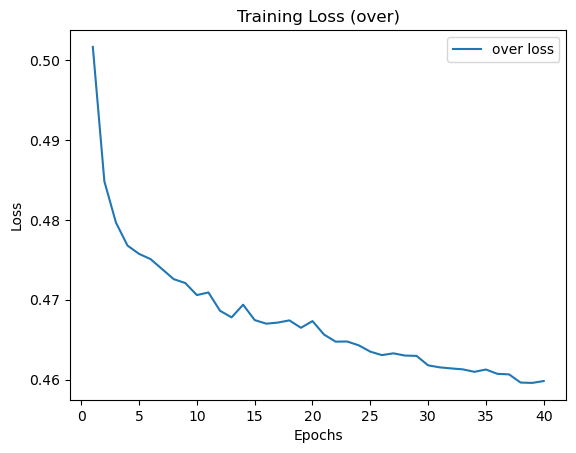

Data type: 'under'

Epoch: 1/40, Loss (training): 0.4640
Epoch: 2/40, Loss (training): 0.4354
Epoch: 3/40, Loss (training): 0.4295
Epoch: 4/40, Loss (training): 0.4273
Epoch: 5/40, Loss (training): 0.4264
Epoch: 6/40, Loss (training): 0.4249
Epoch: 7/40, Loss (training): 0.4236
Epoch: 8/40, Loss (training): 0.4201
Epoch: 9/40, Loss (training): 0.4205
Epoch: 10/40, Loss (training): 0.4189
Epoch: 11/40, Loss (training): 0.4159
Epoch: 12/40, Loss (training): 0.4181
Epoch: 13/40, Loss (training): 0.4163
Epoch: 14/40, Loss (training): 0.4151
Epoch: 15/40, Loss (training): 0.4150
Epoch: 16/40, Loss (training): 0.4151
Epoch: 17/40, Loss (training): 0.4146
Epoch: 18/40, Loss (training): 0.4152
Epoch: 19/40, Loss (training): 0.4124
Epoch: 20/40, Loss (training): 0.4122
Epoch: 21/40, Loss (training): 0.4117
Epoch: 22/40, Loss (training): 0.4121
Epoch: 23/40, Loss (training): 0.4122
Epoch: 24/40, Loss (training): 0.4113
Epoch: 25/40, Loss (training): 0.4110
Epoch: 26/40, Loss (training): 0.4091
E

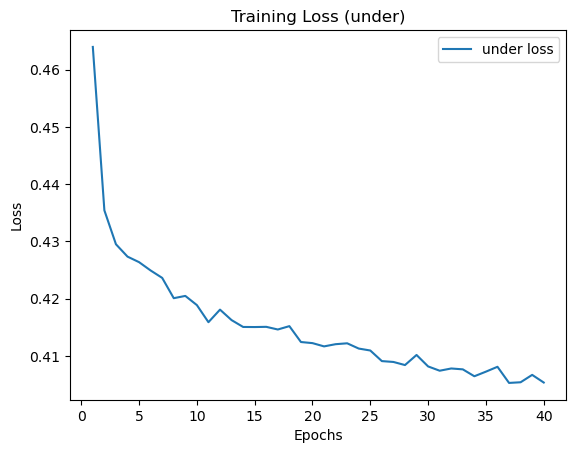

In [35]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

for kind in config:
    print(f"Data type: '{kind}'\n")

    # 1.
    X_train, X_test, y_train, y_test = get_dataset(kind)
    x_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    x_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

    # 2.
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # 3.
    input_dim = X_train.shape[1]
    model, criterion, optimizer = create_model(input_dim)
    
    epochs = 40
    train_losses = []

    # 4
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch: {epoch+1}/{epochs}, Loss (training): {epoch_loss:.4f}')

    # 5
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            preds.extend(torch.round(outputs).cpu().numpy().flatten())
            trues.extend(labels.cpu().numpy().flatten())

    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds)
    roc = roc_auc_score(trues, preds)
    print(f"{kind}: accuracy: {acc:.4f},  F1: {f1:.4f}, ROC-AUC: {roc:.4f}")
    print(classification_report(trues, preds))

    # 6
    results.append({
        "Dataset": kind,
        "Accuracy": acc,
        "F1-score": f1,
        "ROC-AUC": roc
    })

    # 7
    plt.plot(range(1, len(train_losses)+1), train_losses, label=f'{kind} loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss ({kind})')
    plt.legend()
    plt.show()

The model results will also be compared and collected in one table for clarity.

In [36]:
results_df = pd.DataFrame(results)
display(results_df)

,Dataset,Accuracy,F1-score,ROC-AUC
0,orig,0.764921,0.664932,0.738858
1,orig,0.764008,0.677556,0.746927
2,over,0.778247,0.800540,0.778247
3,under,0.793747,0.794524,0.793747


For the original data, the accuracy is around 0.76, F1 around 0.66–0.68, ROC-AUC around 0.74. This means that the model performs moderately well, but has a problem with an unbalanced class distribution (it probably underestimates the results for smokers group).

For oversampled data, accuracy is: 0.78, F1: 0.80, ROC-AUC: 0.78. There is a visible improvement in the F1-score — that is, the model better recognizes both classes (including the minority one).

For the undersampled data, the accuracy is 0.79, F1 is 0.79, and ROC-AUC is 0.79. The model trained on equal classes has better prediction balance, but may have lost some information (because undersampling removes some data).

Ultimately, the best results were obtained with undersampling, which provided stable metrics across all measures.

###

The graphs illustrate previous observations. The model is learning correctly, as evidenced by the decreasing error function as the model progresses through successive epochs. It can also be seen that the learning rate decreases with each successive epoch, as evidenced by the hyperbolic function.

# Testing for the undersampling method

Of the three methods shown above, the undersampling method is selected to demonstrate the effectiveness of other models and optimizers in the model training process.

A function is defined to create three different types of MLP models for classification. Depending on the `model_type` argument, it returns one of the following networks:
- `model1` - a simple feedforward MLP: 32-neuron input layer → ReLU → Dropout(0.2) → 16-neuron hidden layer → ReLU → 1-neuron output → Sigmoid,
- `model2` - a deeper MLP with batch normalization: 128-neuron input → BatchNorm → ReLU → Dropout(0.4) → 64 → 32 hidden layers → ReLU → 1-neuron output → Sigmoid
- `model3` - a residual MLP with skip connection: 64-neuron input → BatchNorm → ReLU → 64-neuron residual layer → BatchNorm → ReLU, added to previous activation → 1-neuron output → Sigmoid.

In [52]:
def build_model(model_type, input_dim=24):
    if model_type == 'model1':
        return nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    elif model_type == 'model2':
        return nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    elif model_type == 'model3':
        class ResidualMLP(nn.Module):
            def __init__(self, input_dim):
                super().__init__()
                self.fc1 = nn.Linear(input_dim, 64)
                self.bn1 = nn.BatchNorm1d(64)
                self.fc2 = nn.Linear(64, 64)
                self.bn2 = nn.BatchNorm1d(64)
                self.fc3 = nn.Linear(64, 1)
                self.relu = nn.ReLU()
                self.sigmoid = nn.Sigmoid()

            def forward(self, x):
                out = self.relu(self.bn1(self.fc1(x)))
                residual = out.clone()
                out = self.relu(self.bn2(self.fc2(out)))
                out = out + residual
                out = self.sigmoid(self.fc3(out))
                return out

        return ResidualMLP(input_dim)
    else:
        raise ValueError("Unknown model type")

A function is defined to create an optimizer for a given model. Depending on `optimizer_name`, it returns:
- `adam` – Adam optimizer with learning rate 0.001,
- `sgd` – Stochastic Gradient Descent with learning rate 0.01.

In [53]:
def build_optimizer(optimizer_name, model):
    if optimizer_name == 'adam':
        return optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == 'sgd':
        return optim.SGD(model.parameters(), lr=0.01)
    else:
        raise ValueError("Unknown optimizer type")

A list of model configurations is defined for experiments, combining three variables:
* model type (`model1`, `model2`, `model3`),
* optimizer (`adam` or `sgd`),
* dataset type (`over` or `under` sampling).

In [54]:
model_configs = [
    ('model1', 'adam', 'over'),
    ('model1', 'sgd', 'over'),
    ('model2', 'adam', 'over'),
    ('model2', 'sgd', 'over'),
    ('model3', 'adam', 'over'),
    ('model3', 'sgd', 'over'),
    ('model1', 'adam', 'under'),
    ('model1', 'sgd', 'under'),
    ('model2', 'adam', 'under'),
    ('model2', 'sgd', 'under'),
    ('model3', 'adam', 'under'),
    ('model3', 'sgd', 'under')
]

A function is defined to perform a single training epoch for a PyTorch model. It iterates over batches from the dataloader, computes the loss, backpropagates gradients, updates model weights using the optimizer and returns the average training loss for the epoch.

In [55]:
from sklearn.model_selection import StratifiedKFold
import copy

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for Xb, yb in dataloader:
        Xb = Xb.to(device)
        yb = yb.to(device).unsqueeze(1)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    return running_loss / len(dataloader.dataset)

A function is defined to evaluate a PyTorch model on a dataset.

In [56]:
def evaluate_model_torch(model, dataloader, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for Xb, yb in dataloader:
            Xb = Xb.to(device)
            out = model(Xb)
            preds.extend(torch.round(out).cpu().numpy().flatten().tolist())
            trues.extend(yb.numpy().flatten().tolist())
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds)
    roc = roc_auc_score(trues, preds)
    return acc, f1, roc

A function is defined to train a PyTorch MLP model using stratified K-fold cross-validation. For each fold, it:

* splits the data into training and validation sets,
* builds the selected model and optimizer,
* trains the model for a number of epochs with early stopping,
* evaluates the model on the validation set using accuracy, F1-score and ROC-AUC.

In [59]:
def train_kfold_mlp(X, y, model_name, optimizer_name,
                    n_splits=5, epochs=50, batch_size=64, patience=6,
                    device=None, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_metrics = []
    fold_losses = []
    best_fold_model = None
    best_fold_f1 = -np.inf

    X = X.copy()
    y = y.copy()
    
    if isinstance(X, np.ndarray):
        import pandas as pd
        X = pd.DataFrame(X)
    if isinstance(y, np.ndarray):
        import pandas as pd
        y = pd.Series(y)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}/{n_splits}, model={model_name}, optimizer={optimizer_name}")
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        input_dim = X_tr.shape[1]
        model = build_model(model_name, input_dim=input_dim).to(device)
        optimizer = build_optimizer(optimizer_name, model)

        train_ds = TensorDataset(torch.tensor(X_tr_scaled, dtype=torch.float32),
                                 torch.tensor(y_tr.values, dtype=torch.float32))
        val_ds = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                               torch.tensor(y_val.values, dtype=torch.float32))
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        criterion = torch.nn.BCELoss()
        best_val_loss = np.inf
        epochs_no_improve = 0
        history_loss = []

        for epoch in range(1, epochs+1):
            train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
            model.eval()
            val_losses = []
            with torch.no_grad():
                for Xb, yb in val_loader:
                    Xb = Xb.to(device)
                    yb = yb.to(device).unsqueeze(1)
                    out = model(Xb)
                    loss = criterion(out, yb)
                    val_losses.append(loss.item() * Xb.size(0))
            val_loss = np.sum(val_losses) / len(val_loader.dataset)
            history_loss.append((train_loss, val_loss))

            if val_loss < best_val_loss - 1e-4:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping: epoch {epoch} (patience={patience})")
                break

        model.load_state_dict(best_model_state)

        acc, f1, roc = evaluate_model_torch(model, val_loader, device)
        print(f"Fold {fold}: Accuracy={acc:.4f}, F1={f1:.4f}, ROC-AUC={roc:.4f}")
        fold_metrics.append({'fold': fold, 'accuracy': acc, 'f1': f1, 'roc': roc})
        fold_losses.append(history_loss)

        if f1 > best_fold_f1:
            best_fold_f1 = f1
            best_fold_model = copy.deepcopy(model)

    accuracies = [m['accuracy'] for m in fold_metrics]
    f1s = [m['f1'] for m in fold_metrics]
    rocs = [m['roc'] for m in fold_metrics]

    summary = {
        'model_name': model_name,
        'optimizer_name': optimizer_name,
        'n_splits': n_splits,
        'accuracy_mean': np.mean(accuracies),
        'accuracy_std': np.std(accuracies),
        'f1_mean': np.mean(f1s),
        'f1_std': np.std(f1s),
        'roc_mean': np.mean(rocs),
        'roc_std': np.std(rocs),
        'per_fold': fold_metrics,
        'fold_losses': fold_losses,
        'best_model': best_fold_model
    }
    return summary

A loop is executed to train all specified MLP model configurations using stratified K-fold cross-validation.

In [60]:
torch.manual_seed(42)
np.random.seed(42)

kfold_results = []
for model_name, opt_name, data_kind in model_configs:
    print("\nConfig:", model_name, opt_name, data_kind)
    X_train, X_test, y_train, y_test = get_dataset(data_kind)
    res = train_kfold_mlp(X_train, y_train, model_name, opt_name,
                         n_splits=5, epochs=40, batch_size=64, patience=8)
    kfold_results.append({
        'Dataset': data_kind,
        'Model': model_name,
        'Optimizer': opt_name,
        'Accuracy_mean': res['accuracy_mean'],
        'Accuracy_std': res['accuracy_std'],
        'F1_mean': res['f1_mean'],
        'F1_std': res['f1_std'],
        'ROC_mean': res['roc_mean'],
        'ROC_std': res['roc_std'],
        'res_obj': res
    })


Config: model1 adam over

Fold 1/5, model=model1, optimizer=adam
Early stopping: epoch 33 (patience=8)
Fold 1: Accuracy=0.7816, F1=0.7978, ROC-AUC=0.7816

Fold 2/5, model=model1, optimizer=adam
Early stopping: epoch 25 (patience=8)
Fold 2: Accuracy=0.7750, F1=0.7966, ROC-AUC=0.7750

Fold 3/5, model=model1, optimizer=adam
Early stopping: epoch 33 (patience=8)
Fold 3: Accuracy=0.7782, F1=0.7995, ROC-AUC=0.7782

Fold 4/5, model=model1, optimizer=adam
Early stopping: epoch 27 (patience=8)
Fold 4: Accuracy=0.7745, F1=0.7928, ROC-AUC=0.7745

Fold 5/5, model=model1, optimizer=adam
Early stopping: epoch 36 (patience=8)
Fold 5: Accuracy=0.7749, F1=0.7935, ROC-AUC=0.7749

Config: model1 sgd over

Fold 1/5, model=model1, optimizer=sgd
Fold 1: Accuracy=0.7790, F1=0.8011, ROC-AUC=0.7790

Fold 2/5, model=model1, optimizer=sgd
Fold 2: Accuracy=0.7710, F1=0.7942, ROC-AUC=0.7710

Fold 3/5, model=model1, optimizer=sgd
Fold 3: Accuracy=0.7735, F1=0.7963, ROC-AUC=0.7735

Fold 4/5, model=model1, optimizer

The DataFrame is created that summarises all MLP configurations and displays them sorted by mean F1-score to identify the best-performing setup.

In [61]:
kfold_df = pd.DataFrame(kfold_results)
display(kfold_df.sort_values(by='F1_mean', ascending=False).reset_index(drop=True))

,Dataset,Model,Optimizer,Accuracy_mean,Accuracy_std,F1_mean,F1_std,ROC_mean,ROC_std,res_obj
0,over,model3,adam,0.783380,0.001119,0.801091,0.002344,0.783380,0.001116,"{'model_name': 'model3', 'optimizer_name': 'ad..."
1,under,model3,adam,0.793955,0.003032,0.800619,0.003534,0.793955,0.003029,"{'model_name': 'model3', 'optimizer_name': 'ad..."
2,under,model1,adam,0.792631,0.002314,0.800560,0.004544,0.792630,0.002308,"{'model_name': 'model1', 'optimizer_name': 'ad..."
3,over,model2,adam,0.780680,0.001793,0.800021,0.002852,0.780680,0.001795,"{'model_name': 'model2', 'optimizer_name': 'ad..."
4,under,model2,adam,0.795121,0.004584,0.799299,0.005179,0.795121,0.004583,"{'model_name': 'model2', 'optimizer_name': 'ad..."
5,under,model2,sgd,0.790550,0.003043,0.797973,0.004949,0.790550,0.003040,"{'model_name': 'model2', 'optimizer_name': 'sg..."
6,over,model2,sgd,0.773940,0.002540,0.797934,0.003300,0.773940,0.002545,"{'model_name': 'model2', 'optimizer_name': 'sg..."
7,under,model3,sgd,0.791118,0.002661,0.797408,0.004112,0.791117,0.002660,"{'model_name': 'model3', 'optimizer_name': 'sg..."
8,over,model3,sgd,0.778642,0.003786,0.797297,0.004625,0.778642,0.003788,"{'model_name': 'model3', 'optimizer_name': 'sg..."
9,over,model1,adam,0.776836,0.002741,0.796036,0.002551,0.776836,0.002745,"{'model_name': 'model1', 'optimizer_name': 'ad..."


The following table shows that:
- For data balancing methods, undersampling performs slightly better. This can be explained, e.g. by the fact that the oversampled data slightly overfitted the model due to duplicated data.
- For model architectures, model 3 appears to be the best, demonstrating the greatest stability and highest performance.
- For different optimizers, the Adam optimizer performs better, especially for the deeper models (2 and 3).

The results also indicate that the best combination is a model trained on undersampled data with the residual model (3) using the Adam optimizer.

## Conclusions

Multi-layer perceptrons tend to perform worse than Random Forest on tabular clinical datasets. This has been observed in studies: deep learning models often underperform on structured biosignal data, whereas tree-based models are more robust. Similarly, "Explainable artificial intelligence driven insights into smoking prediction using machine learning and clinical parameters" showed that classical ML methods can achieve higher predictive accuracy when features are well-defined and not very high-dimensional.

MLPs need a large amount of informative data to learn complex non-linear relationships. In datasets with small number of features that are mostly independent, neural networks struggle to detect less visible patterns. In contrast, models like Random Forest can capture non-linear interactions and variable dependencies.